In [190]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
from hyperbolicity.tree_fitting_methods.hdtree import hdtree
from hyperbolicity.delta import compute_exact_hyperbolicity_naive
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from hyperbolicity.tree_fitting_methods.hyperbolicity_learning import train_distance_matrix
from hyperbolicity.tree_fitting_methods.gromov import gromov_tree
from hyperbolicity.utils import construct_weighted_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

In [191]:
sizes = [15, 15, 15]
probs = [[0.6, 0.15, 0.15],
         [0.15, 0.6, 0.15],
         [0.15, 0.15, 0.6]]
G = nx.stochastic_block_model(sizes, probs)
true_labels = np.array([G.nodes[i]['block'] for i in range(n)])
""" n = len(G.nodes)
print(nx.diameter(G))
n = G.number_of_nodes()
G.add_node(n)
for j in range(n+1):
    G.add_weighted_edges_from([(j, n, 100)]) """

dist_matrix = nx.floyd_warshall_numpy(G)

In [192]:
#tree_opt = hdtree(torch.tensor(dist_matrix), 44, 0.1, 1, 44, 100.0, 20, 200, True, True)

In [193]:
best_weights, losses, deltas, errors, duration = train_distance_matrix(torch.tensor(dist_matrix), 100.0, 20.0, 200, 1, 45, 0.1, True, True)

loss = 1.00869, delta = 0.92471, error = 0.00420: 100%|██████████| 200/200 [00:09<00:00, 21.85it/s]


In [194]:
num_nodes = dist_matrix.shape[0]
edges = torch.triu_indices(num_nodes, num_nodes, offset=1)
distance_optimized = construct_weighted_matrix(best_weights, num_nodes, edges)

In [195]:
new_row = torch.full((1, distance_optimized.shape[1]), 50)
distance_optimized_node = torch.cat((distance_optimized, new_row), dim=0)
new_column = torch.full((distance_optimized_node.shape[0], 1), 50)
distance_optimized_node = torch.cat((distance_optimized_node, new_column), dim=1)
distance_optimized_node[-1,-1] = 0

In [196]:
tree_opt = gromov_tree(distance_optimized_node.numpy(), num_nodes)

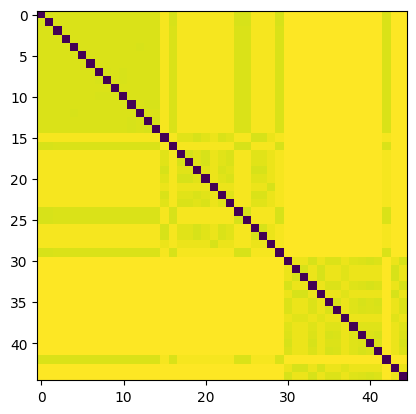

In [197]:
plt.imshow(tree_opt[:-1, :-1])

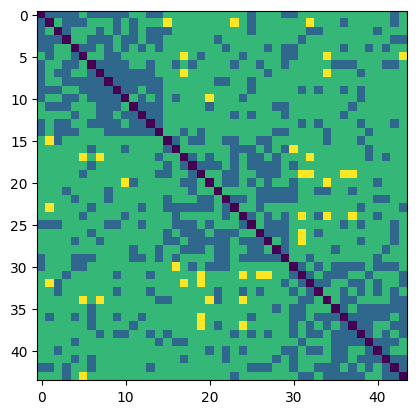

In [198]:
plt.imshow(dist_matrix[:-1, :-1])

In [199]:
Z1 = linkage(dist_matrix, method='ward')
Z2 = linkage(tree_opt[:-1,:-1], method='ward')
cluster_labels1 = fcluster(Z1, t=3, criterion='maxclust') 
cluster_labels2 = fcluster(Z2, t=3, criterion='maxclust') 

def clustering_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm) 
    return cm[row_ind, col_ind].sum() / np.sum(cm)

print(clustering_accuracy(true_labels, cluster_labels1))
print(clustering_accuracy(true_labels, cluster_labels2))

0.8444444444444444
0.8888888888888888


/tmp/ipykernel_3910380/428073159.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z1 = linkage(dist_matrix, method='ward')
/tmp/ipykernel_3910380/428073159.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z2 = linkage(tree_opt[:-1,:-1], method='ward')
